<h1 style="text-align:center; color:#86608E; font-size: 48px">Facial Emotion Recognition</h1>



<h2 style="color:#9370DB;">Import Libraries</h2>


<p style="color:#9370DB;">Le't first impor the libraries we are going to use.</p>

In [99]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from PIL import Image
from sklearn.preprocessing import LabelEncoder


#Importing the evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

#Importing the random value seed
from numpy.random import seed
#Importing the train test split to split the data
from sklearn.model_selection import train_test_split

#Importing the model libraries from tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

#Importing EarlyStopping to use it for stopping at a point
from tensorflow.keras.callbacks import EarlyStopping



<h2 style="color:#9370DB;">Load the Dataset</h2>

In [2]:
#Creating variables for the directory of the data in my labtop

TRAIN = 'data/train/train/'  #This is the dir for the training data
TEST = 'data/test/test/'     #This is the dir for the testing data

In [3]:
#Creating a fun to load the data
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
# convert into dataframe of the training data
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)

#Seeing the head 
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,data/train/train/neutral\Training_87940418.jpg,neutral
1,data/train/train/neutral\Training_6913352.jpg,neutral
2,data/train/train/angry\Training_5630757.jpg,angry
3,data/train/train/neutral\Training_6342271.jpg,neutral
4,data/train/train/sad\Training_55753053.jpg,sad


In [5]:
# convert into dataframe of the training data
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST)

#Seeing the head 
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,data/test/test/angry\PrivateTest_10131363.jpg,angry
1,data/test/test/angry\PrivateTest_10304478.jpg,angry
2,data/test/test/angry\PrivateTest_1054527.jpg,angry
3,data/test/test/angry\PrivateTest_10590091.jpg,angry
4,data/test/test/angry\PrivateTest_1109992.jpg,angry


<h2 style="color:#9370DB;">Exploratory Data Analysis</h2>


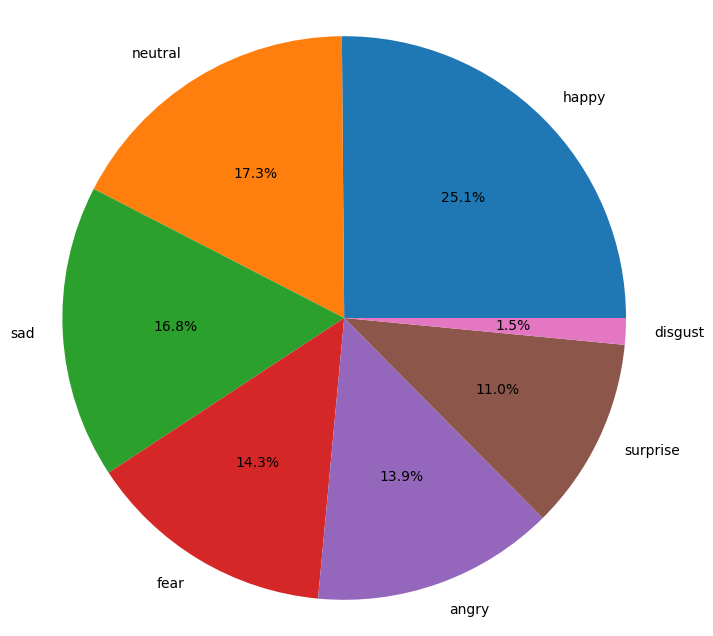

In [14]:
#Let's see how many labels we have in our data

count_values = train['label'].value_counts()

plt.figure(figsize=(8, 8))  # Set the figure size

plt.pie(count_values, labels=count_values.index, autopct='%1.1f%%')
plt.axis('equal')
plt.show()



<p style="color:#9370DB;">As we can see, we have about 25% of the data with happy label and it is the highest one.
On the other hand, we only have 1.5% of disgust data. 
This means that we are dealing with unbalanced data</p>

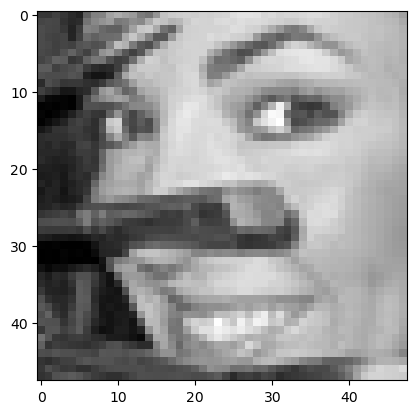

In [7]:
#Let's see the image 50 in our train dataset
img = Image.open(train['image'][50])
plt.imshow(img, cmap='gray');
plt.show()

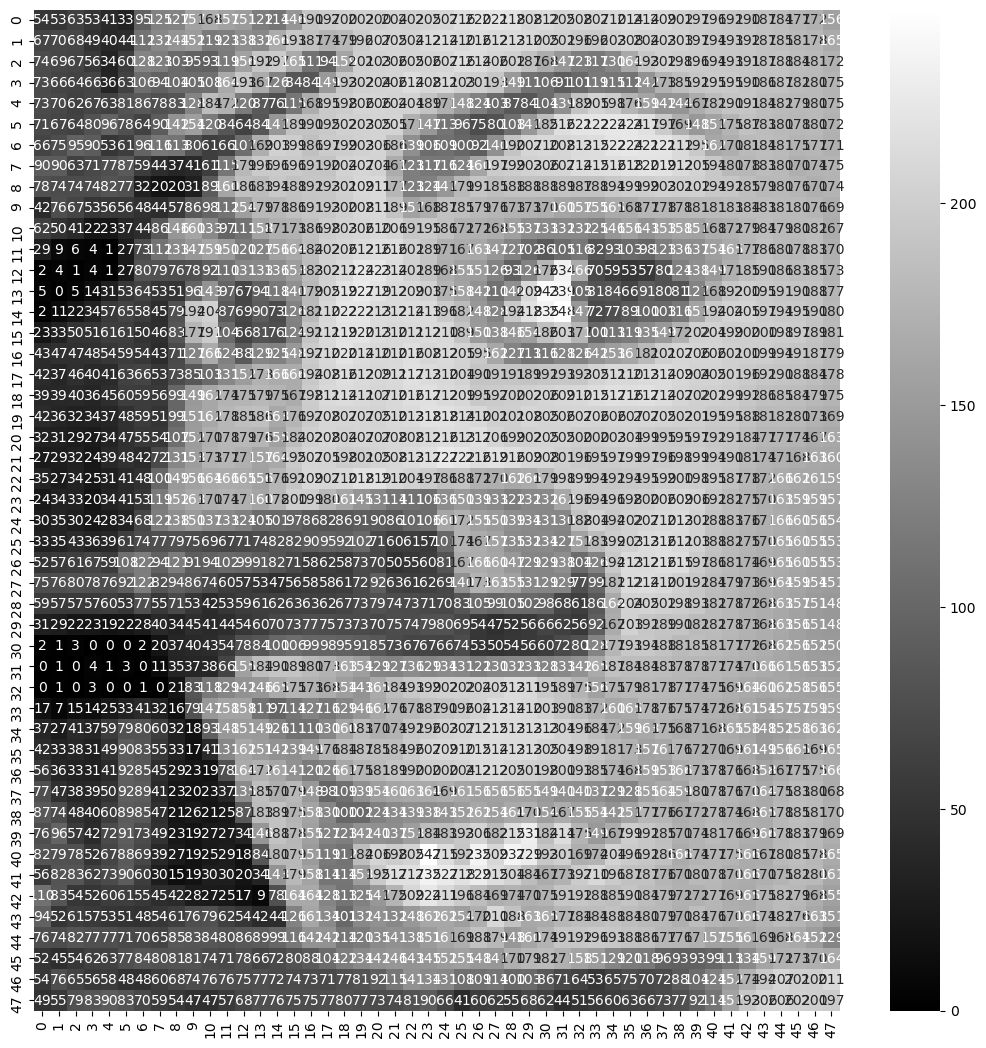

In [8]:
#Seeing the image through the heatmap
plt.figure(figsize=(13, 13))
sns.heatmap(img, annot=True, cmap="gray", fmt=".3g")
plt.show()

In [9]:
# Checking the shape of train
train['image'].shape

(28709,)

In [10]:
# Checking the shape of test
test['image'].shape

(7178,)

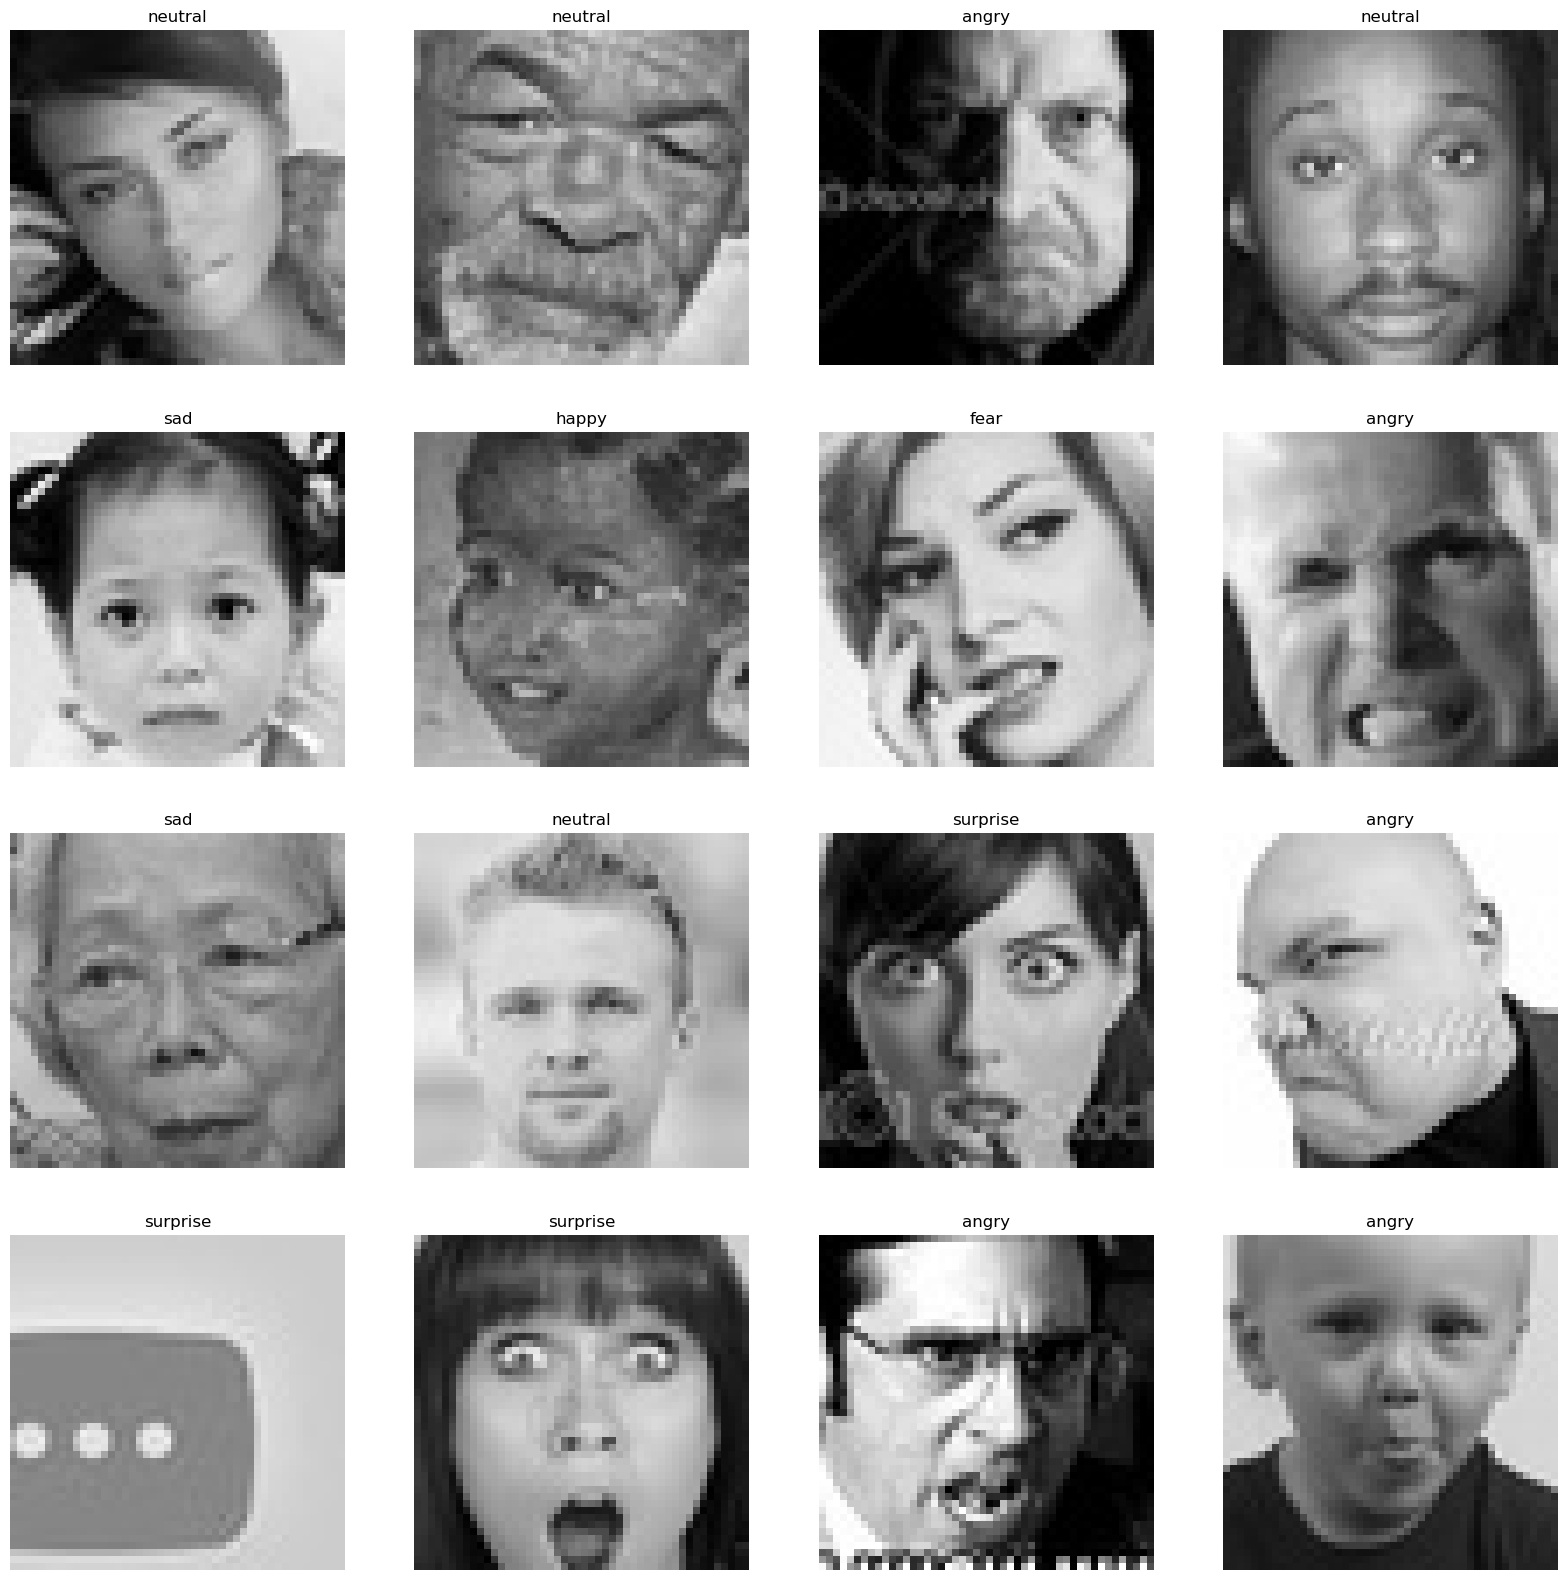

In [15]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:16]

for index, file, label in files.itertuples():
    plt.subplot(4, 4, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')


<h2 style="color:#9370DB;">Feature Extraction</h2>

In [16]:
#Creating a fun to extract the features from the data
def features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [17]:
#Applying the fun to the training data
train_features = features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [18]:
#Applying the fun to the testing data
test_features = features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]


<h2 style="color:#9370DB;">Data Preprocessing</h2>

In [19]:
#Seeing the min value of one of the values
train_features[10].min()
#As we can see, the min value is 0

0

In [20]:
#Seeing the max value of one of the values
train_features[10000].max()


182

In [21]:
# Now, I can normalize image pixels, by dividing the x_train and x_test by the max value
#Before dividing, i have to change their type to float

#Changing the type of x_train
x_train = train_features.astype("float32")
#Changing the type of x_test
x_test = test_features.astype("float32")

#Normalize x_train
x_train /= 255

#Normalize x_test
x_test /= 255

In [22]:
#Seeing the x_train after normalizing
x_train
#As we can see, it is normalized now

array([[[[0.03529412],
         [0.02352941],
         [0.04313726],
         ...,
         [0.92156863],
         [0.92156863],
         [0.9137255 ]],

        [[0.03137255],
         [0.01960784],
         [0.03529412],
         ...,
         [0.91764706],
         [0.91764706],
         [0.91764706]],

        [[0.05882353],
         [0.03529412],
         [0.04313726],
         ...,
         [0.9098039 ],
         [0.9137255 ],
         [0.9137255 ]],

        ...,

        [[0.19607843],
         [0.4392157 ],
         [0.38039216],
         ...,
         [0.48235294],
         [0.4392157 ],
         [0.4       ]],

        [[0.16078432],
         [0.21568628],
         [0.17254902],
         ...,
         [0.50980395],
         [0.4862745 ],
         [0.44313726]],

        [[0.13725491],
         [0.15294118],
         [0.1764706 ],
         ...,
         [0.5529412 ],
         [0.5176471 ],
         [0.50980395]]],


       [[[0.4745098 ],
         [0.40392157],
         [0.37

In [23]:
#Seeing the x_test after normalizing
x_test
#As we can see, it is normalized now

array([[[[0.18039216],
         [0.13333334],
         [0.10196079],
         ...,
         [0.03921569],
         [0.05098039],
         [0.08627451]],

        [[0.19607843],
         [0.10980392],
         [0.08235294],
         ...,
         [0.04313726],
         [0.03921569],
         [0.08235294]],

        [[0.19607843],
         [0.10588235],
         [0.05882353],
         ...,
         [0.08627451],
         [0.09411765],
         [0.08627451]],

        ...,

        [[0.8156863 ],
         [0.7019608 ],
         [0.42352942],
         ...,
         [0.7490196 ],
         [0.8039216 ],
         [0.8       ]],

        [[0.83137256],
         [0.7764706 ],
         [0.58431375],
         ...,
         [0.70980394],
         [0.78431374],
         [0.8       ]],

        [[0.8156863 ],
         [0.7882353 ],
         [0.67058825],
         ...,
         [0.64705884],
         [0.7058824 ],
         [0.7411765 ]]],


       [[[0.21568628],
         [0.12941177],
         [0.21

In [24]:
#Now, let's check one of the images
print('The min value is: ', x_train[0].min())
print('The max value is: ', x_train[10000].max())
#As we can see, the min valu is 0, and the max value is around 1 now after normalizing

The min value is:  0.0
The max value is:  0.7137255


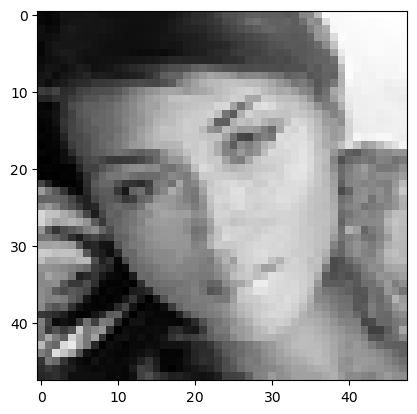

In [25]:
#Let's check if the image has affected after normalizing or not
plt.imshow(x_train[0], cmap="gray")
plt.show()
#As we can see, the image is fine

In [26]:
#Let's see the shape of x_train and x_test
x_train.shape, x_test.shape
#As we can see, the shape now contains only 3 dimension

((28709, 48, 48, 1), (7178, 48, 48, 1))


<h2 style="color:#9370DB;">Convert label to integer</h2>

In [27]:
#Let's see the labels of the training data
train['label']

0        neutral
1        neutral
2          angry
3        neutral
4            sad
          ...   
28704        sad
28705      angry
28706    neutral
28707    neutral
28708    neutral
Name: label, Length: 28709, dtype: object

In [28]:
#Let's see the labels of the testing data
test['label']

0          angry
1          angry
2          angry
3          angry
4          angry
          ...   
7173    surprise
7174    surprise
7175    surprise
7176    surprise
7177    surprise
Name: label, Length: 7178, dtype: object


<p style="color:#9370DB;">As we can see, our labels are not numeric and we cannot use it in the model, as the model only work with numeric data not object data, so we have to convert it first to be able to work with it.</p>

In [29]:
#Now, let's work with the labels of our images

#First, I am going to create labelEncoder
label = LabelEncoder()

#Next, fitting only the training data not the testing data
label.fit(train['label'])

#Then, transforming the training data
y_train = label.transform(train['label'])

#Then, transforming the testing data
y_test = label.transform(test['label'])

In [30]:
#Now, let's see the y_train after converting
y_train
#As we can see, it's numeric now

array([4, 4, 0, ..., 4, 4, 4])

In [31]:
#Now, let's see the y_test after converting
y_test
#As we can see, it's numeric now

array([0, 0, 0, ..., 6, 6, 6])

In [32]:
#Let's see the shape of y_train
print('The shape of y_train is: ', y_train.shape)
#As we can see the shape is (28709,)

The shape of y_train is:  (28709,)


In [33]:
#Let's see the shape of y_test
print('The shape of y_test is: ', y_test.shape)
#As we can see the shape is (7178,)

The shape of y_test is:  (7178,)


In [34]:
#Now, let's use to_categorical to convert y_train and y_test. Also, renaming them
y_train = to_categorical(y_train, num_classes=7)

y_test = to_categorical(y_test, num_classes=7)

In [35]:
#Let's see the shape of the new y_train and y_test
y_train.shape, y_test.shape
#As we can see, the shape now is different

((28709, 7), (7178, 7))

In [36]:
#Let's take a look at y_train
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [37]:
#Let's take a look at y_test
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)


<h3 style="color:#9370DB;">Validation Data</h3>

In [38]:
#The value of seed(random value)
s = 101
#The value of epochs
p = 100
#The value of batch_size
b = 100

In [39]:
#Splitting the training data to validation data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.10, 
                                                      stratify=y_train, 
                                                      random_state=s, 
                                                      shuffle=True)

In [40]:
#Printing the shape of the traning and validation data
print("x_train shape -> ", x_train.shape)
print("y_train shape -> ", y_train.shape)
print("x_valid shape -> ", x_valid.shape)
print("y_valid shape -> ", y_valid.shape)

x_train shape ->  (25838, 48, 48, 1)
y_train shape ->  (25838, 7)
x_valid shape ->  (2871, 48, 48, 1)
y_valid shape ->  (2871, 7)



<h2 style="color:#9370DB;">Model Creation</h2>

In [41]:
#Creating a varible for the input shape
input_shape = (48, 48, 1) 

#Creating a varible for the classes we have in our data
output = 7

In [44]:
#Let's now create the model

#using Sequential() to create the model
model = Sequential()

#Adding the 2D Convolutional Layer to the model, then using a filter of 32,  kernel_size=(3,3)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

#Adding the 2D Convolutional Layer to the model, then using a filter of 64,  kernel_size=(3,3)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

#Adding the pool_size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding dropout layer with 0.25
model.add(Dropout(0.25))



#Adding the 2D Convolutional Layer to the model, then using a filter of 128,  kernel_size=(3,3)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

#Adding the pool_size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding the 2D Convolutional Layer to the model, then using a filter of 128,  kernel_size=(3,3)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

#Adding the pool_size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding dropout layer with 0.25
model.add(Dropout(0.25))


#Adding Flatten layer
model.add(Flatten())

#Adding 1024 Neurons and relu to the actibation
model.add(Dense(1024, activation='relu'))


#Adding dropout layer with 0.5
model.add(Dropout(0.5))


#For the final layer, adding 7 Neurons and a softmax activation
model.add(Dense(output, activation="softmax"))


#Compiling the model, putting categorical_crossentropy to the loss, adam to optimizer, and accuracy to metrics
model.compile(optimizer="adam", metrics=["accuracy"], loss="categorical_crossentropy")

In [45]:
#Seeing the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                 


<h2 style="color:#9370DB;">Model Training</h2>

In [46]:
#Creating an early stoping
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,         
                               restore_best_weights=True)

In [47]:
#Fitting the model and using early stopping on it 
history=model.fit(x=x_train,
                  y=y_train,
                  batch_size=b,
                  epochs=p,
                  validation_data=(x_valid,y_valid),
                  callbacks=[early_stopping])

Epoch 1/100
808/808 [==============================] - 248s 295ms/step - loss: 1.7860 - accuracy: 0.2675 - val_loss: 1.6520 - val_accuracy: 0.3333
Epoch 2/100
808/808 [==============================] - 272s 336ms/step - loss: 1.5609 - accuracy: 0.3897 - val_loss: 1.3905 - val_accuracy: 0.4692
Epoch 3/100
808/808 [==============================] - 352s 436ms/step - loss: 1.3773 - accuracy: 0.4666 - val_loss: 1.2401 - val_accuracy: 0.5259
Epoch 4/100
808/808 [==============================] - 357s 442ms/step - loss: 1.2768 - accuracy: 0.5078 - val_loss: 1.1958 - val_accuracy: 0.5528
Epoch 5/100
808/808 [==============================] - 379s 469ms/step - loss: 1.2122 - accuracy: 0.5337 - val_loss: 1.1785 - val_accuracy: 0.5528
Epoch 6/100
808/808 [==============================] - 353s 437ms/step - loss: 1.1619 - accuracy: 0.5569 - val_loss: 1.1442 - val_accuracy: 0.5733
Epoch 7/100
808/808 [==============================] - 363s 449ms/step - loss: 1.1249 - accuracy: 0.5746 - val_loss: 1

In [48]:
#Seeing the metrics of the model
model.metrics_names

['loss', 'accuracy']

In [49]:
#Seeing the history of the model
model.history.history

{'loss': [1.7859628200531006,
  1.5609264373779297,
  1.3773126602172852,
  1.276843786239624,
  1.2122150659561157,
  1.1618993282318115,
  1.124948263168335,
  1.0821582078933716,
  1.0466322898864746,
  1.0131734609603882,
  0.9842001795768738,
  0.9528181552886963,
  0.9154632091522217,
  0.8880693912506104,
  0.8653689026832581,
  0.8330639600753784,
  0.8147725462913513,
  0.7879724502563477,
  0.7530472874641418],
 'accuracy': [0.2675129771232605,
  0.3896586298942566,
  0.46656087040901184,
  0.5077792406082153,
  0.5337487459182739,
  0.5568929314613342,
  0.5746187567710876,
  0.5907965302467346,
  0.6077869534492493,
  0.6193203926086426,
  0.632827639579773,
  0.6426581144332886,
  0.6564362645149231,
  0.6688985228538513,
  0.6773356795310974,
  0.687437117099762,
  0.6950615644454956,
  0.7040405869483948,
  0.7207601070404053],
 'val_loss': [1.6519520282745361,
  1.3905351161956787,
  1.240100383758545,
  1.1957675218582153,
  1.1784580945968628,
  1.144160270690918,
  1

In [50]:
#Creating a dataframe of the history of the model
history = pd.DataFrame(model.history.history)

#Seeing the head
history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.785963,0.267513,1.651952,0.333333
1,1.560926,0.389659,1.390535,0.469175
2,1.377313,0.466561,1.240100,0.525949
3,1.276844,0.507779,1.195768,0.552769
4,1.212215,0.533749,1.178458,0.552769


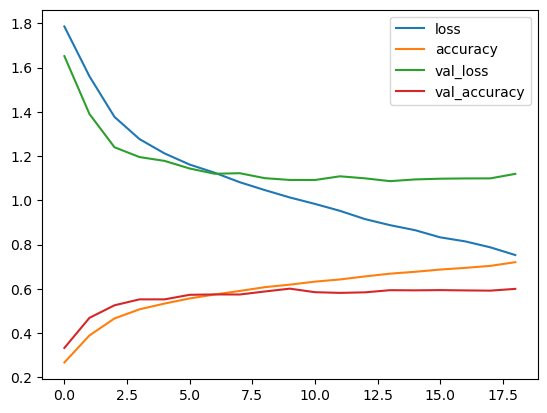

In [51]:
#Plotting the history of the model
history.plot();


<h2 style="color:#9370DB;">Model Evaluation</h2>

In [89]:
#Evaluating the model of x_test and Y_test
model.evaluate(x_test, y_test)

225/225 [==============================] - 24s 107ms/step - loss: 1.0815 - accuracy: 0.6062


[1.0815223455429077, 0.6061577200889587]

In [90]:
#Seeing the scores of the model
model_score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", model_score[0])
print("Test accuracy:", model_score[1])

Test loss: 1.0815223455429077
Test accuracy: 0.6061577200889587


In [91]:
#Seeing the predicted values of the model
pred = model.predict(x_test)
pred

225/225 [==============================] - 24s 106ms/step


array([[4.2281669e-01, 1.0781598e-02, 4.9629465e-02, ..., 6.0061853e-02,
        1.9687794e-01, 2.9562309e-04],
       [6.5228820e-01, 3.3627709e-03, 1.9351925e-01, ..., 7.5110137e-03,
        4.1131563e-02, 5.9074204e-02],
       [6.0180116e-02, 2.6790875e-03, 1.3474581e-01, ..., 1.1071203e-01,
        4.6853787e-01, 1.7908458e-01],
       ...,
       [4.5724013e-03, 7.1571507e-05, 4.3778520e-02, ..., 2.7016658e-02,
        3.1452574e-02, 8.8635617e-01],
       [1.4653888e-02, 1.7461743e-03, 4.2019192e-02, ..., 3.2599615e-03,
        1.7246305e-03, 9.3651348e-01],
       [4.3315338e-03, 4.7134501e-05, 7.1204990e-02, ..., 3.2194969e-04,
        4.3963123e-04, 8.7161177e-01]], dtype=float32)

In [92]:
#Seeing the shape of the predicted values
pred.shape

(7178, 7)

In [93]:
#Seeing the first value of the predicted value
pred[0]

array([4.2281669e-01, 1.0781598e-02, 4.9629465e-02, 2.5953680e-01,
       6.0061853e-02, 1.9687794e-01, 2.9562309e-04], dtype=float32)

In [94]:
np.argmax(pred[0])

0

In [95]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([0, 0, 5, ..., 6, 6, 6], dtype=int64)

In [96]:
#The shape of y_pred
y_pred.shape

(7178,)


<h2 style="color:#9370DB;">Plot the Results</h2>

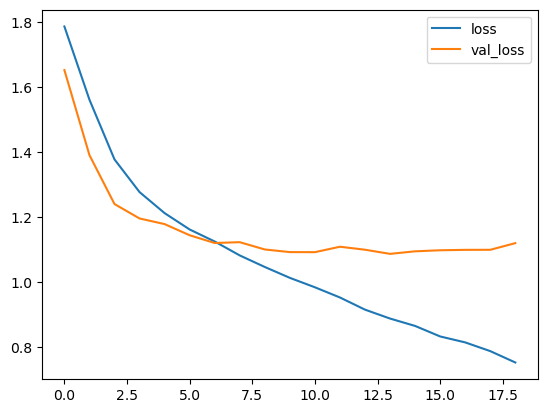

In [52]:
#Seeing loss and val_loss from the graph
history[["loss", "val_loss"]].plot()
plt.show()

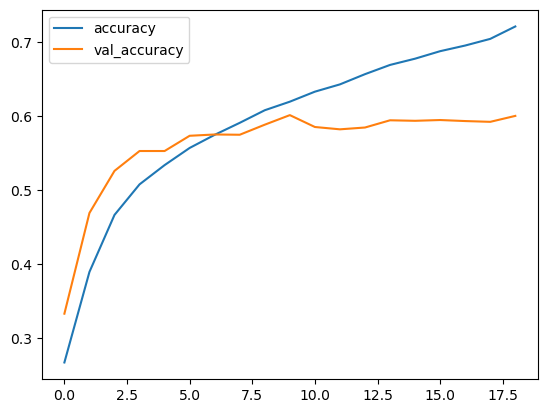

In [53]:
#Seeing the accuracy and val_accuracy from the graph
history[["accuracy", "val_accuracy"]].plot()
plt.show()

In [56]:
history['accuracy']

0     0.267513
1     0.389659
2     0.466561
3     0.507779
4     0.533749
5     0.556893
6     0.574619
7     0.590797
8     0.607787
9     0.619320
10    0.632828
11    0.642658
12    0.656436
13    0.668899
14    0.677336
15    0.687437
16    0.695062
17    0.704041
18    0.720760
Name: accuracy, dtype: float64

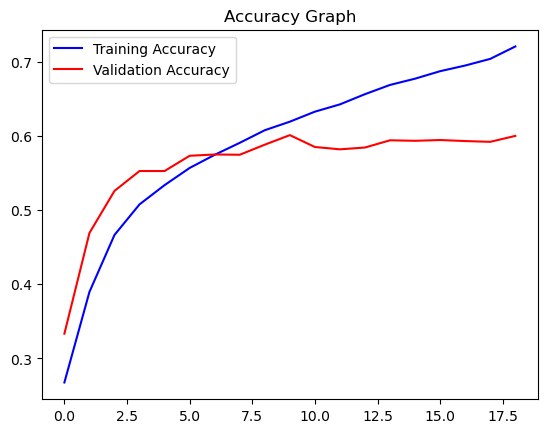

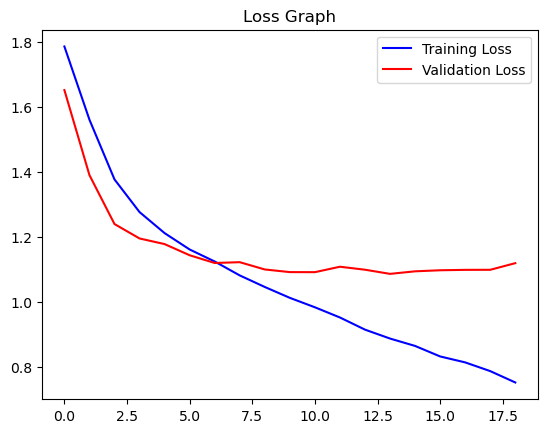

In [58]:
acc = history['accuracy']
val_acc = history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()


<h2 style="color:#9370DB;">Prediction with testing Data</h2>


<p style="color:#9370DB;">First prediction</p>

Original Output: sad
1/1 [==============================] - 1s 744ms/step
Predicted Output: sad


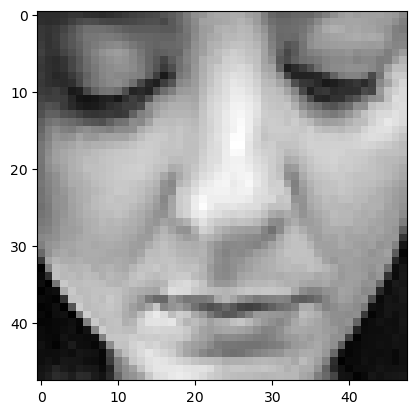

In [59]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

#As we can see, the original output is sad and our predicted value is sad as well


<p style="color:#9370DB;">Second prediction</p>

Original Output: angry
1/1 [==============================] - 0s 130ms/step
Predicted Output: angry


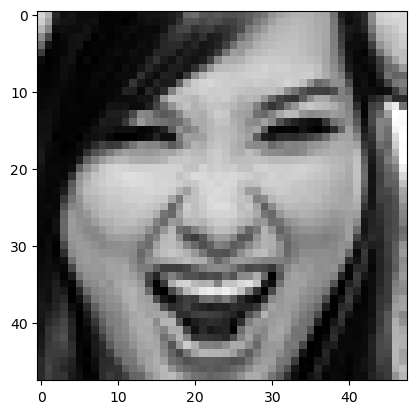

In [62]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

#As we can see, the original output is angry and our predicted value is angry as well


<p style="color:#9370DB;">Third prediction</p>

Original Output: sad
1/1 [==============================] - 0s 71ms/step
Predicted Output: sad


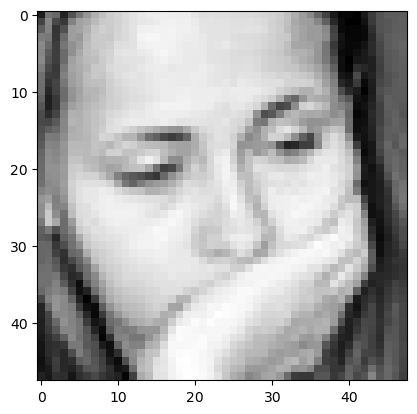

In [63]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');


#As we can see, the original output is sad and our predicted value is sad as well


<p style="color:#9370DB;">Fourth prediction</p>

Original Output: fear
1/1 [==============================] - 0s 195ms/step
Predicted Output: fear


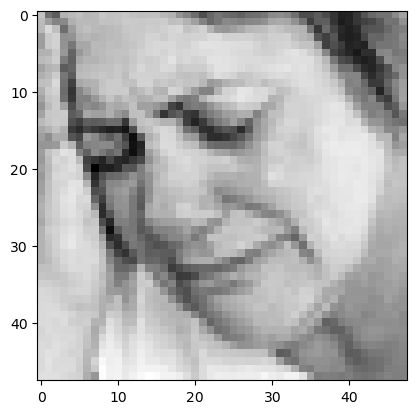

In [66]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

#As we can see, the original output is fear and our predicted value is fear as well


<p style="color:#9370DB;">Fifth prediction</p>

Original Output: happy
1/1 [==============================] - 0s 263ms/step
Predicted Output: happy


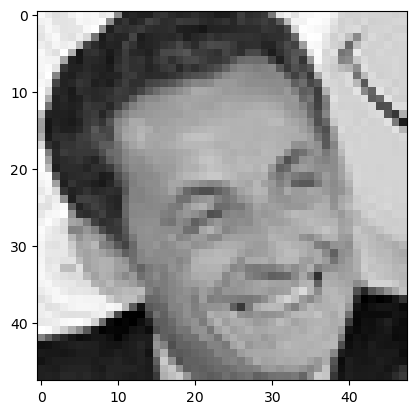

In [68]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

#As we can see, the original output is happy and our predicted value is happy as well


<p style="color:#9370DB;">Sixth prediction</p>

Original Output: fear
1/1 [==============================] - 0s 246ms/step
Predicted Output: fear


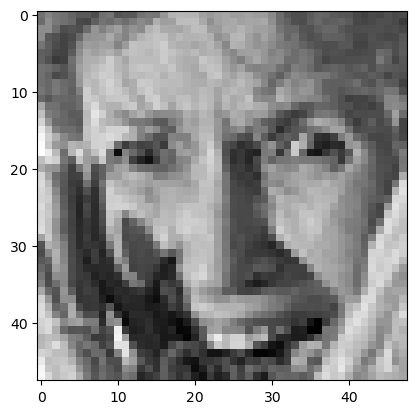

In [70]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

#As we can see, the original output is fear and our predicted value is fear as well


<h2 style="color:#9370DB;">Saving the model</h2>

In [71]:
#Saving the model
model.save("model.h5")


<h2 style="color:#9370DB;">Loading the model</h2>

In [72]:
#Fitching the model to use it for prediction
pre_model = tf.keras.models.load_model("model.h5")


<h3 style="color:#9370DB;">Prediction on the saving model</h3>

In [73]:
#Changing the dim of the predicted value
pred_emotion = pre_model.predict(np.expand_dims(x_test[400], 0))

1/1 [==============================] - 1s 531ms/step


In [74]:
np.argmax(pred_emotion)

0

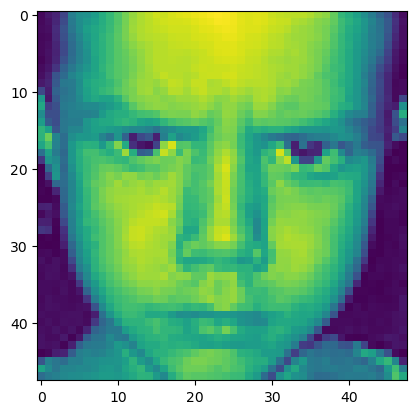

In [80]:
#Seeing the image of the predicted value
plt.imshow(x_test[400].reshape(48, 48))
plt.show()

In [81]:
#Changing the dim of the predicted value
pred_emotion2 = pre_model.predict(np.expand_dims(x_test[5000], 0))

1/1 [==============================] - 0s 271ms/step


In [82]:
np.argmax(pred_emotion2)

4

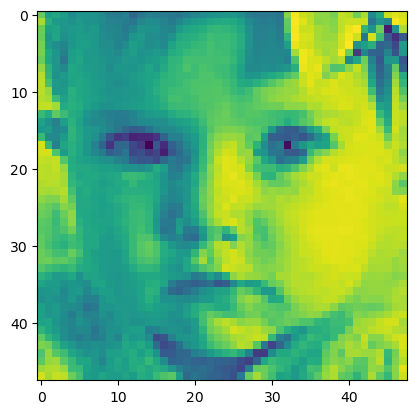

In [83]:
#Seeing the image of the predicted value
plt.imshow(x_test[5000].reshape(48, 48))
plt.show()

In [86]:
#Changing the dim of the predicted value
pred_emotion3 = pre_model.predict(np.expand_dims(x_test[5], 0))

1/1 [==============================] - 0s 165ms/step


In [87]:
np.argmax(pred_emotion3)

2

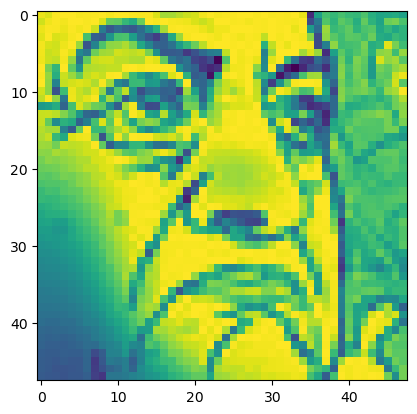

In [88]:
#Seeing the image of the predicted value
plt.imshow(x_test[5].reshape(48, 48))
plt.show()


<h1 style="text-align:center; color:#86608E; font-size: 48px">Thank You</h1>